<a href="https://colab.research.google.com/github/BryanVerduga/Proyecto1_Verduga/blob/main/Proyecto2(Series_Tiempos).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Bryan Verduga**

**Presentacion datos de flujo vehicular en estaciones de peajes de Buenos Aires durante año 2017,2018,2019**


In [90]:
#librerias iniciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

#cargamos data y le damos una vista rapida

data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

**Nos centraremos en una estacion de peaje y un tipo de pago, la idea es predecir un valor futuro de flujo para esta estacion con este metodo de pago.**

In [91]:
#los dataset tienen las mismas columnas asi que podemos unirlos
dataset = pd.concat([data_2019, data_2018, data_2017])

#usaremos la estacion Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

<ipython-input-91-5f6c48228a36>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)


,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [92]:
#pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [93]:
#corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True)
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


**Terminamos de construir la data que usaremos para generar los modelos**


In [94]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


**ANALISIS EXPLORATORIO**

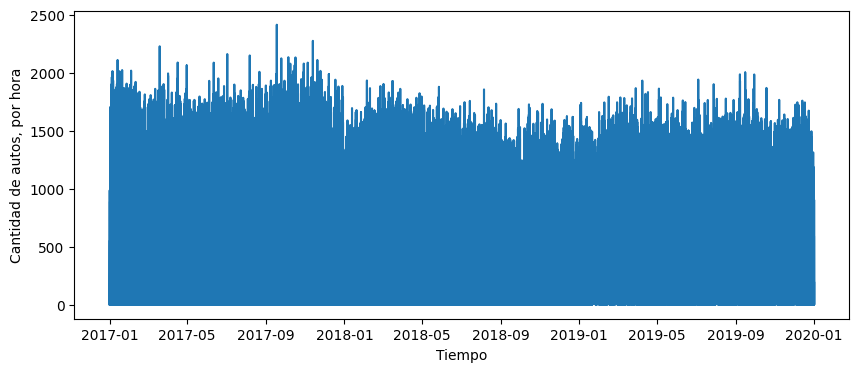

In [95]:
#graficamos nuestros datos, tal como están
plt.figure(figsize = (10,4))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [96]:
#agrupemos por día ya que la visualizacion año mes no es muy amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


<ipython-input-96-bf20e8b531a1>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diario = dataset.resample('D', on = 'fecha').sum()


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


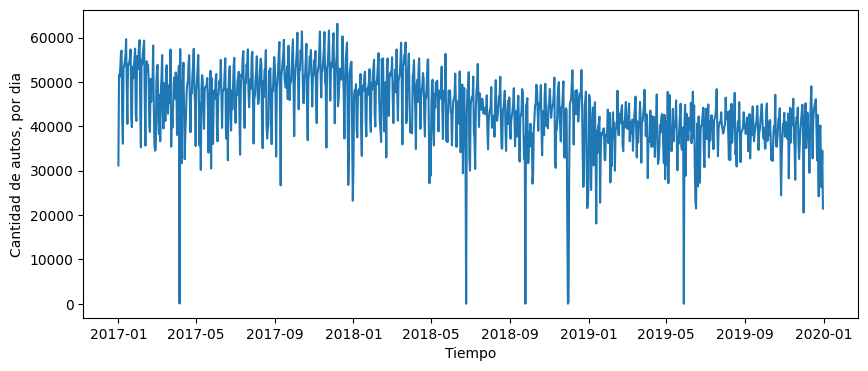

In [97]:
#veamos como se ve
plt.figure(figsize = (10,4))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

**Por la forma en que se comporta y se ve el grafico es claro que tenemos algunos datos atipicos que pueden influir en el prognostico\
¿ Como podriamos quitarlos ?**


In [98]:
#observamos valores atipicos
diario_atipico = diario[diario.cantidad_pasos <= 10000]
diario_atipico

,cantidad_pasos
fecha,
2017-04-06,40
2018-06-25,0
2018-09-25,0
2018-11-30,0
2018-12-01,350
2019-05-29,0


**Se toma la decision de reemplazar eso valores atípicos mediante la interpolacion.**\
La interpolación es el proceso de encontrar un valor entre dos puntos en una línea o una curva.



In [99]:
diario.cantidad_pasos[diario.cantidad_pasos <=10000] = np.nan

In [100]:
print(diario.isna().sum())
diario = diario.interpolate(method='nearest', k = 4)
print(diario.isna().sum())

cantidad_pasos    6
dtype: int64
cantidad_pasos    0
dtype: int64


**Se soluciona el problema**

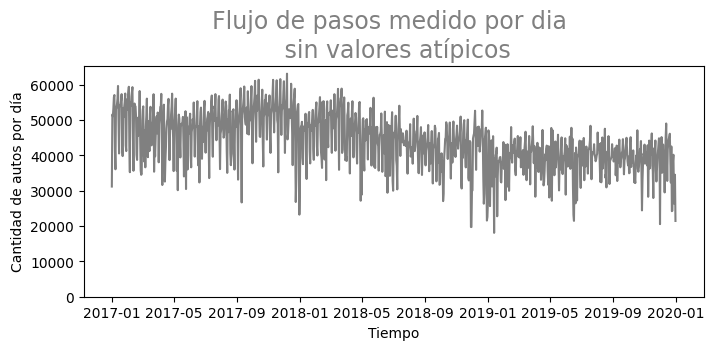

In [101]:
plt.figure(figsize = (8,3))
plt.plot(diario.index, diario.cantidad_pasos, color = 'grey')
plt.title("Flujo de pasos medido por dia \n sin valores atípicos", color= 'grey', fontsize= 17)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos por día')
plt.ylim(ymin=0)
plt.show()

**Nos podrian entrar otro tipo de preguntas, como por ejemplo que día hay mas flujo de automoviles, que flujo de autos es mayor si livianos o pesados?, o tambien cual es la forma mas habitual de pago de los vehiculos en el peaje, esto puedo ser telepeaje, efectivo, entre otras.**

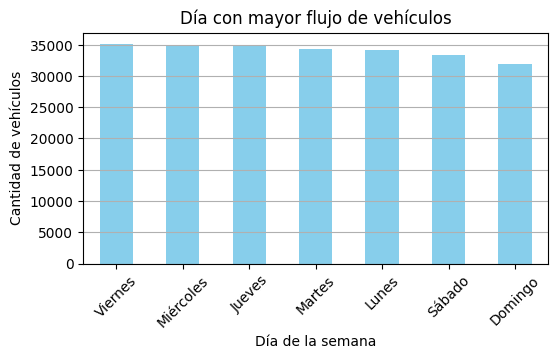

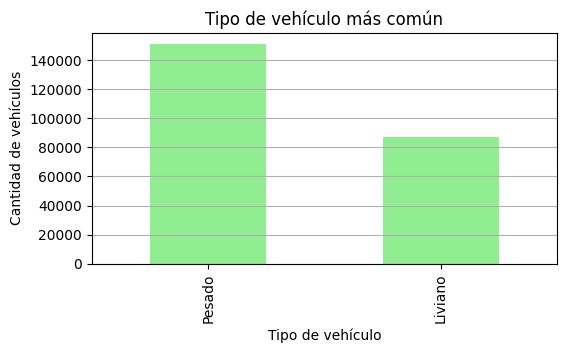

In [102]:
data = dataset.copy()

#gráfico de barras para el día con más flujo de vehículos
day_counts = data['dia'].value_counts()
plt.figure(figsize=(6, 3))
day_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad de vehículos')
plt.title('Día con mayor flujo de vehículos')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

#gráfico de barras para el tipo de vehículo más común
vehicle_counts = data['tipo_vehiculo'].value_counts()
plt.figure(figsize=(6, 3))
vehicle_counts.plot(kind='bar', color='lightgreen')
plt.xlabel('Tipo de vehículo')
plt.ylabel('Cantidad de vehículos')
plt.title('Tipo de vehículo más común')
plt.grid(axis='y')
plt.show()



**PARTIMOS CON MODELO**

In [103]:
!pip install prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpola3psqy/yao3jsff.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpola3psqy/24lxit80.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94629', 'data', 'file=/tmp/tmpola3psqy/yao3jsff.json', 'init=/tmp/tmpola3psqy/24lxit80.json', 'output', 'file=/tmp/tmpola3psqy/prophet_modelyakaab4q/prophet_model-20230731012643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:26:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:26:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


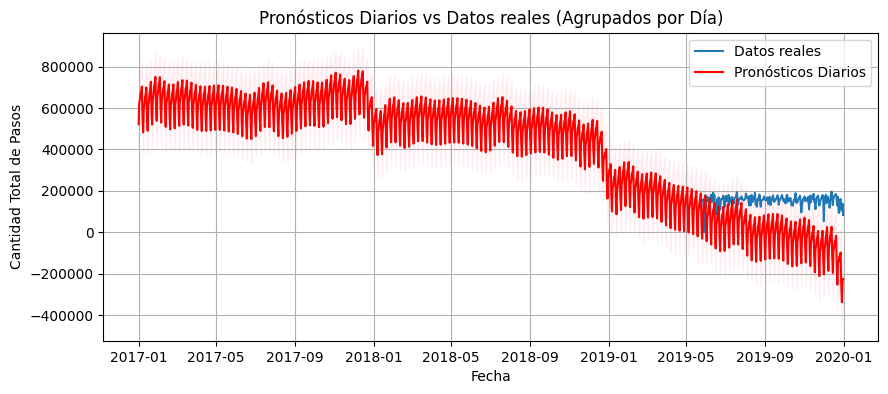

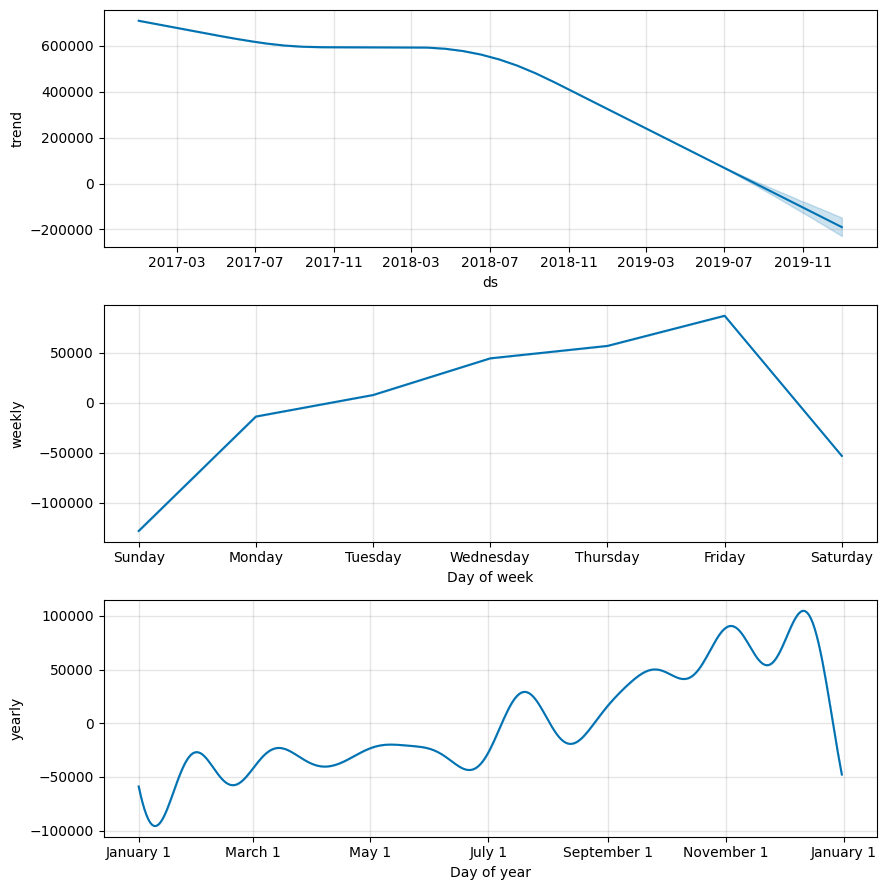

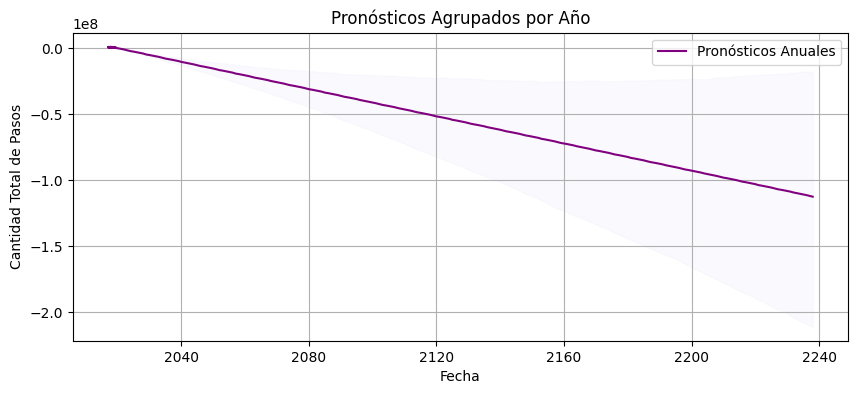

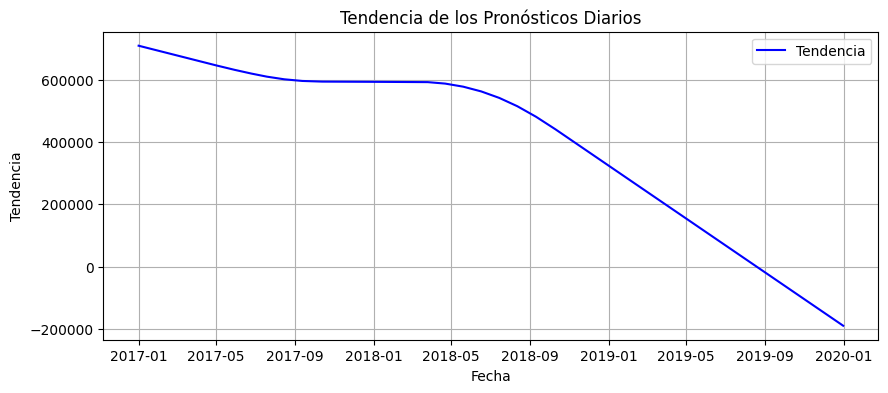

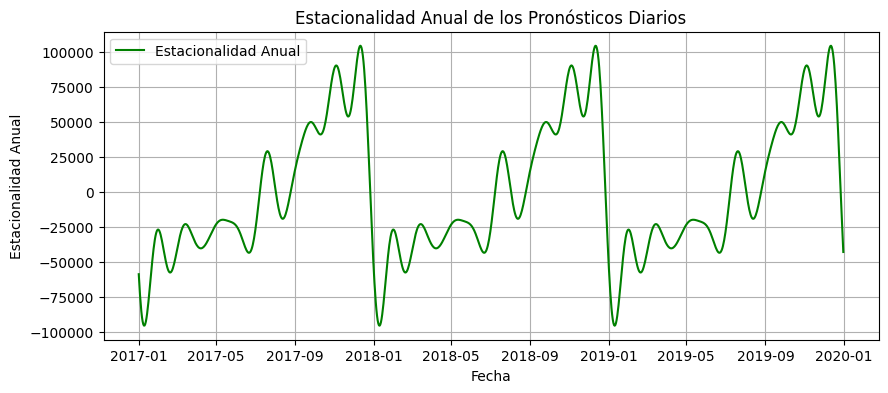

In [104]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

data = dataset.copy()
#preparamos
data['fecha'] = pd.to_datetime(data['fecha'])
data['cantidad_total_pasos'] = data.groupby(['fecha'])['cantidad_pasos'].transform('sum')

#agrupamos por dia
daily_data = data.resample('D', on='fecha')['cantidad_total_pasos'].sum().reset_index()

#creamos datos necesarios para adaptar prophet
prophet_data = daily_data.rename(columns={'fecha': 'ds', 'cantidad_total_pasos': 'y'})

#Entrenamiento del modelo Prophet
train_size = int(len(prophet_data) * 0.8)  #usaremos el 80% de los datos para entrenamiento

train_data = prophet_data.iloc[:train_size]
test_data = prophet_data.iloc[train_size:]

model = Prophet()
model.fit(train_data)

#realizamos prognosticos diarios
future_daily = model.make_future_dataframe(periods=len(test_data), freq='D')  # Pronosticamos tantos datos como tenemos en el conjunto de prueba, con frecuencia diaria
forecast_daily = model.predict(future_daily)

#evaluacion de la precision
plt.figure(figsize=(10, 4))
plt.plot(test_data['ds'], test_data['y'], label='Datos reales')
plt.plot(forecast_daily['ds'], forecast_daily['yhat'], label='Pronósticos Diarios', color='red')
plt.fill_between(forecast_daily['ds'], forecast_daily['yhat_lower'], forecast_daily['yhat_upper'], color='pink', alpha=0.2)
plt.xlabel('Fecha')
plt.ylabel('Cantidad Total de Pasos')
plt.title('Pronósticos Diarios vs Datos reales (Agrupados por Día)')
plt.grid(True)
plt.legend()
plt.show()

#interpretacion componentes del modelo
fig = model.plot_components(forecast_daily)
plt.show()

#prognostico agrupado por año
future_yearly = model.make_future_dataframe(periods=len(test_data), freq='Y')  #pronosticamos tantos datos como tenemos en el conjunto de prueba, con frecuencia anual
forecast_yearly = model.predict(future_yearly)

plt.figure(figsize=(10, 4))
plt.plot(forecast_yearly['ds'], forecast_yearly['yhat'], label='Pronósticos Anuales', color='purple')
plt.fill_between(forecast_yearly['ds'], forecast_yearly['yhat_lower'], forecast_yearly['yhat_upper'], color='lavender', alpha=0.2)
plt.xlabel('Fecha')
plt.ylabel('Cantidad Total de Pasos')
plt.title('Pronósticos Agrupados por Año')
plt.grid(True)
plt.legend()
plt.show()

#imprimir la tendencia y la estacionalidad
plt.figure(figsize=(10, 4))
plt.plot(forecast_daily['ds'], forecast_daily['trend'], label='Tendencia', color='blue')
plt.xlabel('Fecha')
plt.ylabel('Tendencia')
plt.title('Tendencia de los Pronósticos Diarios')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(forecast_daily['ds'], forecast_daily['yearly'], label='Estacionalidad Anual', color='green')
plt.xlabel('Fecha')
plt.ylabel('Estacionalidad Anual')
plt.title('Estacionalidad Anual de los Pronósticos Diarios')
plt.grid(True)
plt.legend()
plt.show()
